# 向量点击注意力

In [1]:
import torch
import torch.nn.functional as F

x1 = torch.randn(2, 3, 4)
x2 = torch.randn(2, 5, 4)

raw_weights = torch.bmm(x1, x2.transpose(1, 2))
print(raw_weights)

attn_weights = F.softmax(raw_weights, dim=2)
print(attn_weights)

attn_output = torch.bmm(attn_weights, x2)
print(attn_output)

tensor([[[ 0.3333, -2.2001,  2.2486, -0.8846, -0.3558],
         [-0.4180,  1.3982, -1.8591, -0.6430,  0.9360],
         [ 1.0270,  2.0279,  0.2964, -0.4284, -2.2356]],

        [[ 0.4519,  2.2074,  1.2542,  4.2554, -1.0178],
         [ 1.1710,  1.2589, -1.0832, -0.7314, -1.5427],
         [-1.3542, -0.2371,  1.0645, -0.8977,  0.7781]]])
tensor([[[0.1154, 0.0092, 0.7834, 0.0341, 0.0579],
         [0.0829, 0.5100, 0.0196, 0.0662, 0.3212],
         [0.2235, 0.6081, 0.1077, 0.0521, 0.0086]],

        [[0.0185, 0.1069, 0.0412, 0.8291, 0.0043],
         [0.4145, 0.4526, 0.0435, 0.0619, 0.0275],
         [0.0395, 0.1208, 0.4439, 0.0624, 0.3334]]])
tensor([[[-0.2393,  1.7228,  0.3522, -0.0884],
         [ 0.4250, -0.7208, -0.3677, -0.4187],
         [ 0.5571, -0.0916, -0.6291, -0.9572]],

        [[-1.4887, -0.7217, -1.1843, -0.1904],
         [-0.9828, -1.6027, -0.7789, -0.0550],
         [-0.4734, -0.4829, -1.5558,  0.6575]]])


# 缩放向量点积注意力

In [3]:
import torch
import torch.nn.functional as F

x1 = torch.randn(2, 3, 4)
x2 = torch.randn(2, 5, 4)

raw_weights = torch.bmm(x1, x2.transpose(1, 2))
print(raw_weights)

scale_factor = x1.size(-1)**5
scaled_weights = raw_weights / scale_factor
print(scaled_weights)

attn_weights = F.softmax(raw_weights, dim=2)
print(attn_weights)

attn_output = torch.bmm(attn_weights, x2)
print(attn_output)

tensor([[[ 3.3367e-01, -1.0050e+00,  1.5537e+00,  1.0320e+00,  5.1897e-01],
         [-1.2600e+00,  3.1312e+00,  6.1341e-01,  1.2293e+00,  4.3964e-01],
         [-3.1846e+00,  6.7512e+00,  4.7322e+00,  2.0783e+00,  3.3038e+00]],

        [[ 1.6897e+00, -1.3332e+00,  6.1474e-02,  1.6162e+00,  8.3588e-01],
         [ 4.4416e-01, -2.5810e-03,  1.0998e-02, -6.2443e-01,  3.7046e-02],
         [ 2.2747e+00, -8.7907e-02,  1.8418e+00,  2.4764e+00,  1.1056e+00]]])
tensor([[[ 3.2585e-04, -9.8143e-04,  1.5172e-03,  1.0078e-03,  5.0681e-04],
         [-1.2304e-03,  3.0578e-03,  5.9904e-04,  1.2005e-03,  4.2933e-04],
         [-3.1099e-03,  6.5930e-03,  4.6213e-03,  2.0295e-03,  3.2263e-03]],

        [[ 1.6501e-03, -1.3019e-03,  6.0033e-05,  1.5784e-03,  8.1629e-04],
         [ 4.3375e-04, -2.5205e-06,  1.0740e-05, -6.0980e-04,  3.6178e-05],
         [ 2.2214e-03, -8.5847e-05,  1.7986e-03,  2.4184e-03,  1.0797e-03]]])
tensor([[[1.2717e-01, 3.3345e-02, 4.3076e-01, 2.5566e-01, 1.5306e-01],
         

In [7]:
x1.size(-1)**0.5

2.0

In [1]:
%reset -f
sentences = [
    ["咖哥 喜欢 小冰", "<sos> KaGe likes XiaoBing", "KaGe likes XiaoBing <eos>"],
    ["我 爱 学习 人工智能", "<sos> I love studying AI", "I love studying AI <eos>"],
    ["深度学习 改变 世界", "<sos> DL changed the world", "DL changed the world <eos>"],
    ["自然 语言 处理 很 强大", "<sos> NLP is so powerful", "NLP is so powerful <eos>"],
    ["神经网络 非常 复杂", "<sos> Neural-Nets are complex", "Neural-Nets are complex <eos>"]
]
word_list_cn, word_list_en = [], []
for s in sentences:
    word_list_cn.extend(s[0].split())
    word_list_en.extend(s[1].split())
    word_list_en.extend(s[2].split())
word_list_cn = list(set(word_list_cn))
word_list_en = list(set(word_list_en))

word_2_idx_cn = {w: i for i, w in enumerate(word_list_cn)}
word_2_idx_en = {w: i for i, w in enumerate(word_list_en)}

idx_2_word_cn = {i: w for i, w in enumerate(word_list_cn)}
idx_2_word_en = {i: w for i, w in enumerate(word_list_en)}

voc_size_cn = len(word_list_cn)
voc_size_en = len(word_list_en)

print(f"句子数量: {len(sentences)}")
print(f"中文词汇表大小: {voc_size_cn}")
print(f"英文词汇表大小: {voc_size_en}")
print(f"中文词汇到索引: {word_2_idx_cn}")
print(f"英文词汇到索引: {word_2_idx_en}")

句子数量: 5
中文词汇表大小: 18
英文词汇表大小: 20
中文词汇到索引: {'咖哥': 0, '语言': 1, '神经网络': 2, '喜欢': 3, '自然': 4, '复杂': 5, '很': 6, '深度学习': 7, '爱': 8, '改变': 9, '非常': 10, '世界': 11, '我': 12, '处理': 13, '强大': 14, '小冰': 15, '人工智能': 16, '学习': 17}
英文词汇到索引: {'powerful': 0, 'AI': 1, 'love': 2, 'XiaoBing': 3, 'the': 4, 'studying': 5, 'world': 6, 'I': 7, 'complex': 8, 'so': 9, 'DL': 10, 'NLP': 11, 'is': 12, 'likes': 13, 'Neural-Nets': 14, '<eos>': 15, 'are': 16, '<sos>': 17, 'KaGe': 18, 'changed': 19}


In [2]:
import numpy as np
import torch
import random

def make_data(sentences):
    random_sentence = random.choice(sentences)
    encoder_input = np.array([[word_2_idx_cn[w] for w in random_sentence[0].split()]])
    decoder_input = np.array([[word_2_idx_en[w] for w in random_sentence[1].split()]])
    target = np.array([[word_2_idx_en[w] for w in random_sentence[2].split()]])
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    target = torch.LongTensor(target)
    return encoder_input, decoder_input, target

encoder_input, decoder_input, target = make_data(sentences)

# 1. 定义 Attention 类

In [3]:
import torch.nn as nn

class Attention(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, decoder_context, encoder_context):
        scores = torch.matmul(decoder_context, encoder_context.transpose(-2, -1))
        attn_weights = nn.functional.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, encoder_context)
        return context, attn_weights

# 2. 重构 Decoder 类

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__() 
        self.hidden_size = hidden_size
        self.embedding  = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        
    def forward(self, inputs, hidden):
        embedded = self.embedding(inputs)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

class DecoderWithAttention(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.attention = Attention()
        self.out = nn.Linear(2*hidden_size, output_size)
    
    def forward(self, dec_input, hidden, enc_output):
        embedded = self.embedding(dec_input)
        rnn_output, hidden = self.rnn(embedded, hidden)
        context, attn_weights = self.attention(rnn_output, enc_output)
        dec_output = torch.cat((rnn_output, context), dim=-1)
        dec_output = self.out(dec_output)
        return dec_output, hidden, attn_weights

n_hidden = 128
encoder = Encoder(voc_size_cn, n_hidden)
print(f"编码器: {encoder}")
decoder = DecoderWithAttention(n_hidden, voc_size_en)
print(f"解码器: {decoder}")

编码器: Encoder(
  (embedding): Embedding(18, 128)
  (rnn): RNN(128, 128, batch_first=True)
)
解码器: DecoderWithAttention(
  (embedding): Embedding(20, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (attention): Attention()
  (out): Linear(in_features=256, out_features=20, bias=True)
)


# 重构 Seq2Seq 类

In [5]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, hidden, decoder_input):
        encoder_output, encoder_hidden = self.encoder(encoder_input, hidden)
        decoder_hidden = encoder_hidden
        decoder_output, _, attn_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
        return decoder_output, attn_weights

model = Seq2Seq(encoder, decoder)

print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18, 128)
    (rnn): RNN(128, 128, batch_first=True)
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(20, 128)
    (rnn): RNN(128, 128, batch_first=True)
    (attention): Attention()
    (out): Linear(in_features=256, out_features=20, bias=True)
  )
)


In [6]:
def train_seq2seq(model, creterion, optimizer, epochs):
    for epoch in range(epochs):
        encoder_input, decoder_input, target = make_data(sentences)
        hidden = torch.zeros(1, encoder_input.size(0), n_hidden)
        optimizer.zero_grad()
        output, _ = model(encoder_input, hidden, decoder_input)
        loss = creterion(output.view(-1, voc_size_en), target.view(-1))
        if (epoch + 1) % 100 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss:.10f}")
        loss.backward()
        optimizer.step()

epochs = 10000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_seq2seq(model, criterion, optimizer, epochs)

Epoch: 100, Loss: 0.0272615440
Epoch: 200, Loss: 0.0090444554
Epoch: 300, Loss: 0.0066235126
Epoch: 400, Loss: 0.0037379779
Epoch: 500, Loss: 0.0021453858
Epoch: 600, Loss: 0.0016583723
Epoch: 700, Loss: 0.0018214842
Epoch: 800, Loss: 0.0014865668
Epoch: 900, Loss: 0.0009100959
Epoch: 1000, Loss: 0.0009493972
Epoch: 1100, Loss: 0.0008070107
Epoch: 1200, Loss: 0.0005178676
Epoch: 1300, Loss: 0.0004403264
Epoch: 1400, Loss: 0.0005363423
Epoch: 1500, Loss: 0.0003673592
Epoch: 1600, Loss: 0.0003162081
Epoch: 1700, Loss: 0.0003506806
Epoch: 1800, Loss: 0.0003072136
Epoch: 1900, Loss: 0.0002908275
Epoch: 2000, Loss: 0.0002109164
Epoch: 2100, Loss: 0.0002201548
Epoch: 2200, Loss: 0.0001928857
Epoch: 2300, Loss: 0.0001671400
Epoch: 2400, Loss: 0.0001782255
Epoch: 2500, Loss: 0.0001585653
Epoch: 2600, Loss: 0.0001231944
Epoch: 2700, Loss: 0.0001355316
Epoch: 2800, Loss: 0.0001089747
Epoch: 2900, Loss: 0.0000969120
Epoch: 3000, Loss: 0.0001100717
Epoch: 3100, Loss: 0.0001023716
Epoch: 3200, Loss

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = ["Arial Unicode MS"]
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

def visualize_attention(source_sentence, predicted_sentence, atten_weights):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(atten_weights, annot=True, cbar=False,
                     xticklabels=source_sentence.split(),
                     yticklabels=predicted_sentence,
                     cmap="Greens")
    plt.xlabel("源序列")
    plt.ylabel("目标序列")
    plt.show()

咖哥 喜欢 小冰 -> ['KaGe', 'likes', 'likes']


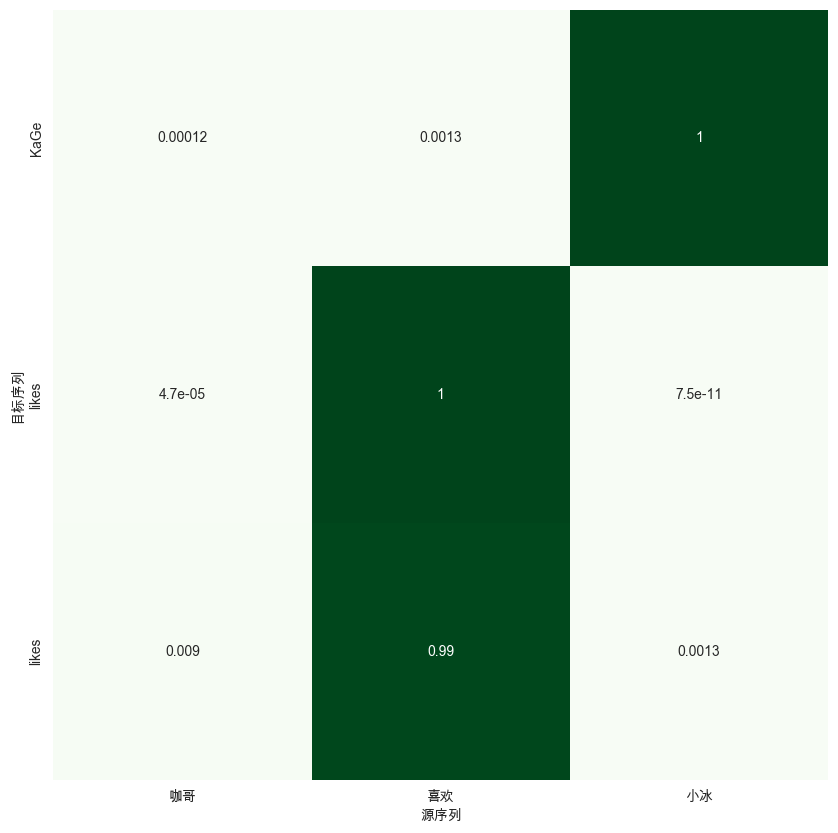

自然 语言 处理 很 强大 -> ['NLP', 'is', 'so', 'NLP', 'NLP']


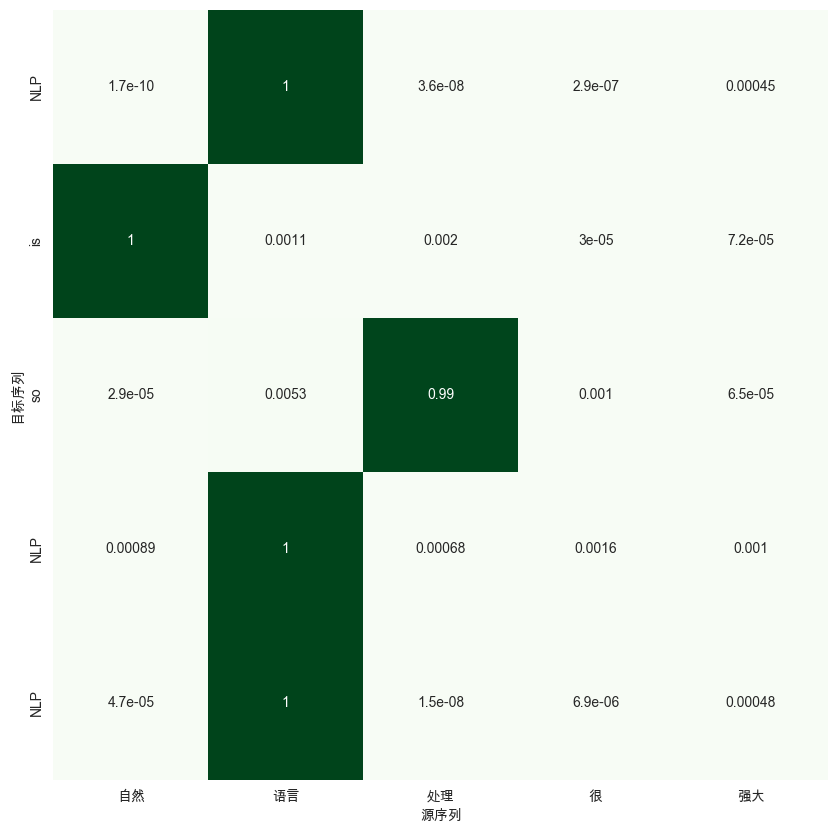

In [8]:
def test_seq2seq(model, source_sentence):
    encoder_input = np.array([[word_2_idx_cn[w] for w in source_sentence.split()]])
    decoder_input = np.array([word_2_idx_en["<sos>"]] + [word_2_idx_en["<eos>"]]*(len(encoder_input[0])-1))
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input).unsqueeze(0)
    hidden = torch.zeros(1, encoder_input.size(0), n_hidden)
    predict,  attn_weights = model(encoder_input, hidden, decoder_input)
    predict = predict.data.max(2, keepdim=True)[1]
    print(f"{source_sentence} -> {[idx_2_word_en[n.item()] for n in predict.squeeze()]}")
    attn_weights = attn_weights.squeeze(0).detach().numpy()
    visualize_attention(source_sentence, [idx_2_word_en[n.item()] for n in predict.squeeze()], attn_weights)

test_seq2seq(model, "咖哥 喜欢 小冰")
test_seq2seq(model, "自然 语言 处理 很 强大")